## General Histogram

Start by importing dataset:

In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib_inline
from iminuit import Minuit
from matplotlib.colors import LogNorm

import daqman2py.evalrois.lib.evalrois as evalrois
from daqman2py.evalrois.lib.fitting import Gaussian

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
plt.style.use("../assets/SetLZStyle.mplstyle")

f1 = (
    "/home/emiz/projects/projectdata/XeNu/Run15p1_04042023_bPMT970V_SiPMV_Sweep.parquet"
)
f2 = "/home/emiz/projects/projectdata/XeNu/Run16_1-9_SiPM_V_sweep_rois.parquet"

roi_data = ak.from_parquet(f1)

Which has the following RQs:


In [2]:
# | label : roidata-fields
roi_data.fields

['event_id', 'ch_id', 'roi_id', 'integral', 'peak_amplitude', 'sipm_v_ch0']

Then make a 4-D [histogram](https://hist.readthedocs.io/en/latest/) with the following axes:


In [3]:
# | label : roidata-histaxes
h1 = evalrois.make_hist(v_bins=6, v_start=49, v_stop=55, roi_data=roi_data)
h1.axes.name

('roi_integral', 'roi_peak_amplitude', 'ch_id', 'sipm_v')

## Combined SiPM ROI Integral Spectra

-   We can sum over certain axes to get a preview of how the SPE area changes with bias voltage
-   Gain curves are visible here as shifts to larger SPE mean


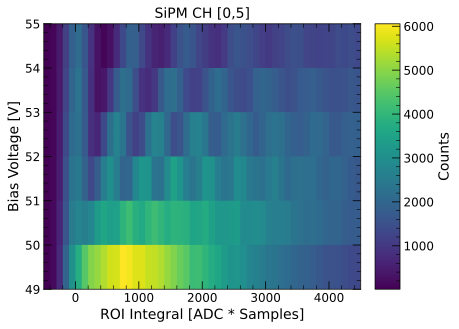

In [4]:
# | label: 15-1-roi-integ-vs-bias-v
fig, ax = plt.subplots()
artists = h1[{"roi_peak_amplitude": sum, "ch_id": sum}].plot(ax=ax, flow=None)
ax.set(title="SiPM CH [0,5]")
fig.axes[1].set(ylabel="Counts")
artists[0].set_rasterized(True)  # svg doesn't play nice in 2-D

## ROI Integral Spectra for Single SiPM Channel

-   We can slice our histogram again to look at SPE area spectra for a single channel, then stack by voltage
-   At 49 and 50V, we cannot really resolve SPEs on a single channel
-   This may be different on another channel or possible if we had better statistics, but ultimately this discourages trying to resolve SPEs at lower voltages

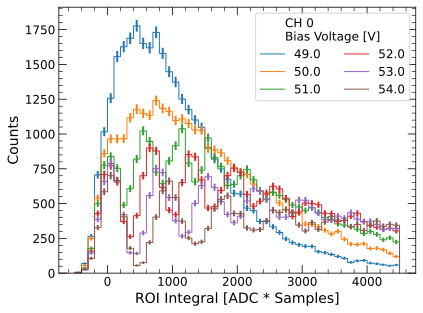

In [5]:
# | label: 15-1-roi-integ-vs-bias-v-stack

sipm_ch = 0
fig, ax = plt.subplots()
roi_integral_stack = h1[:, sum, complex(0, sipm_ch), :].stack("sipm_v")
roi_integral_stack.plot(ax=ax, flow=None)
ax.set(ylabel="Counts")
ax.legend(title=f"CH {sipm_ch}\n{h1.axes[3].label}", ncols=2, labels=[round(h_s.name[0],2) for h_s in roi_integral_stack]);  # fmt: skip

## Example of Fitting to Spectrum

## Spectrum Example

-   Looking at one channel, at a specific voltage, there are a few peaks clearly evident
-   Around 0 are noise fluctuations, followed by the SPE, DPE, TPE, etc. peaks
-   Fit to the first four peaks to get SPE, DPE, and TPE peaks

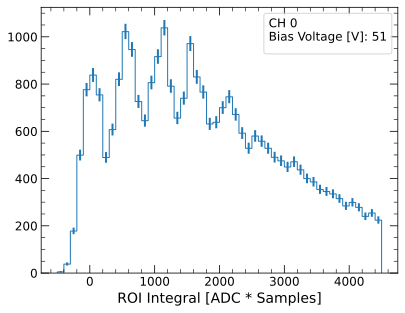

In [6]:
# | label: 15-1-roi-integ-vs-bias-v-51

sipm_v = 51
fig, ax = plt.subplots()
h_test = h1[:, sum, complex(0, sipm_ch), complex(0, sipm_v)]
h_test.plot(ax=ax, flow=None)
ax.legend(title=f"CH {sipm_ch}\n{h1.axes[3].label}: {sipm_v}", labels="");  # fmt: skip

## Fit First Guess

-   Provide a fit range and the approximate peak locations, found by inspection
-   Heights and widths for a first guess are subsequently generated


In [7]:
# | label: 15-1-fit-first-guess

fit_range = slice(-400j, 1900j, None)  # Complex numbers are data coordinates
# This relies on scipy to find peak widths, but we can also override it
first_guess = h_test.get_gaus_params_from_peak_loc([0, 550, 1100, 1500])

## Check First Guess

-   Create an instance of `Gaussian` with 4 peaks, corresponding to sum of 4 gaussians
-   Create a least-squares function to minimize
-   Create a [`Minuit`](https://iminuit.readthedocs.io/en/stable/about.html) instance for performing the fit
    -   Optionally inspect the first guess curve


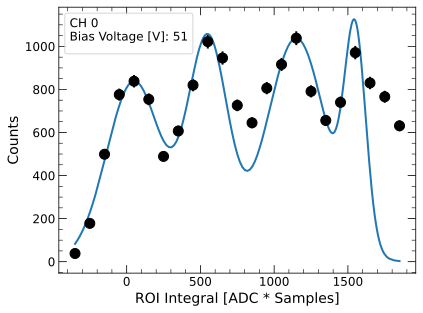

In [8]:
# | label: 15-1-check-first-guess
# | code-line-numbers: 1,2|3|4|7

n_peaks = 4
curve = Gaussian(n_peaks)
lsqs = h_test[fit_range].get_least_squares(curve.sumgaus)
m = Minuit(lsqs, *first_guess, name=curve.get_sumgaus_param_names())
fig, ax = plt.subplots()
ax.set(ylabel="Counts", xlabel=h1.axes[0].label)
ax.legend(title=f"CH {sipm_ch}\n{h1.axes[3].label}: {sipm_v}", labels="");  # fmt: skip
m.visualize()

## Perform Fit

-   Call `MIGRAD` to perform the fit


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


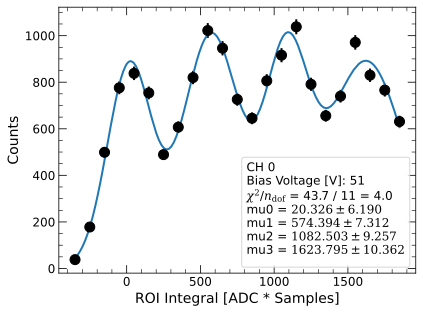

In [9]:
# | label: 15-1-perform-fit

fig, ax = plt.subplots()
ax.set(ylabel="Counts", xlabel=h1.axes[0].label)
m.migrad()
m.visualize()
fit_info = [
    f"CH {sipm_ch}",
    f"{h1.axes[3].label}: {sipm_v}",
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    if "mu" in p:
        fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

ax.legend(title="\n".join(fit_info));  # fmt: skip

# SiPM Gain Curves

## Run 15

-   Perform the same fitting process on each SiPM channel at each bias voltage in the dataset, excluding 50V
-   Estimate overall SPE mean by averaging means of SPE, DPE, and TPE peaks
    -   $\mu_{overall} = (\mu_{SPE} + \frac{\mu_{DPE}}{2} + \frac{\mu_{TPE}}{3}) \div 3$


In [10]:
voltage_range = slice(51j, 55j, None)
sipm_channels = [0, 1, 2, 3, 4, 5]
h1 = evalrois.make_hist(
    v_bins=6, v_start=49, v_stop=55, roi_data=roi_data, integral_nbins=1000
)
fit_val_df, fit_err_df = evalrois.get_spe_fits(
    h1, sipm_channels, voltage_range, peak_sep=500, rebin=20, peak_width_override=120
)
fit_val_df["spe_mean"] = (
    fit_val_df["mu1"] + (fit_val_df["mu2"] / 2) + (fit_val_df["mu3"] / 3)
) / 3
fit_val_df.to_csv("files/Run15.1_SPE_fit_values.csv", index=False)

-   During Run 15, only 6 channels were operational. Gain appeared linear down to 51V. 50V and below were excluded due to poor fits from lack of resolution.

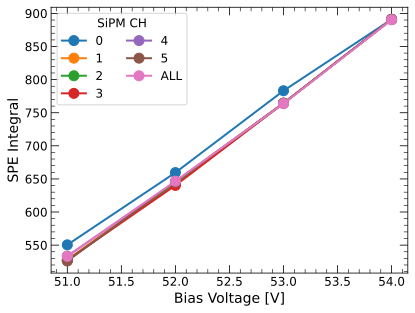

In [11]:
# | label: 15-1-gain-curves

fig, ax = plt.subplots()
fit_val_df.groupby(["sipm_ch"]).plot(x="sipm_v", y="spe_mean", ax=ax, marker="o")
# groupby here is used strictly to retrieve channel labels, not to perform calculations
ch_labels = fit_val_df.groupby(["sipm_ch"]).mean().index.to_list()
ax.legend(title="SiPM CH", labels=ch_labels, ncols=2)
ax.set(xlabel=h1.axes[3].label, ylabel="SPE Integral");  # fmt: skip

## Run 16

In [69]:
roi_data = ak.from_parquet(f2)
h1 = evalrois.make_hist(
    v_bins=9, v_start=50, v_stop=52.25, roi_data=roi_data, integral_nbins=1000
)

-    For Run 16, bias voltages were swept in smaller steps to try and determine the minimum voltage at which SPEs were reliably visible.

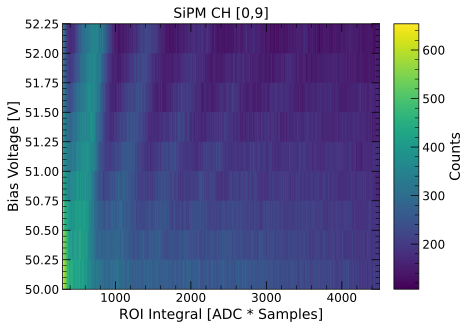

In [70]:
# | label: roi-integ-vs-bias-v-16

fig, ax = plt.subplots()
artists = h1[
    {"roi_integral": slice(300j, None, None), "roi_peak_amplitude": sum, "ch_id": sum}
].plot(ax=ax, flow=None)
ax.set(title="SiPM CH [0,9]")
fig.axes[1].set(ylabel="Counts")
artists[0].set_rasterized(True)

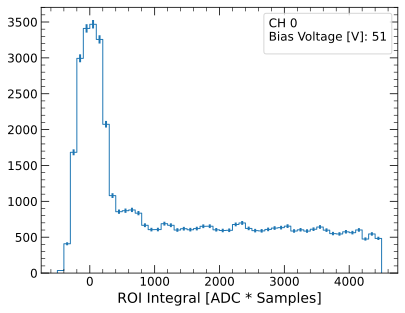

In [128]:
sipm_v = 51
fig, ax = plt.subplots()
h_test = h1[
    {
        "roi_integral": slice(None, None, 20j),
        "roi_peak_amplitude": sum,
        "ch_id": complex(0, sipm_ch),
        "sipm_v": complex(0, sipm_v),
    }
]
h_test.plot(ax=ax, flow=None)
ax.legend(title=f"CH {sipm_ch}\n{h1.axes[3].label}: {sipm_v}", labels="");  # fmt: skip

In [129]:
fit_range = slice(-400j, 2000j, None)  # Complex numbers are data coordinates
# This relies on scipy to find peak widths, but we can also override it
first_guess = h_test.get_gaus_params_from_peak_loc(
    [0, 650, 1200, 1800], width_override=190
)
first_guess

[3468.0, 50.0, 190, 880.0, 650.0, 190, 666.0, 1250.0, 190, 653.0, 1850.0, 190]

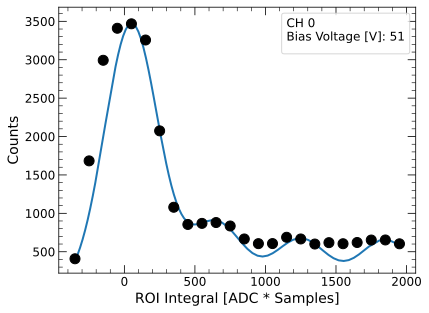

In [130]:
n_peaks = 4
curve = Gaussian(n_peaks)
lsqs = h_test[fit_range].get_least_squares(curve.sumgaus)
m = Minuit(lsqs, *first_guess, name=curve.get_sumgaus_param_names())
fig, ax = plt.subplots()
ax.set(ylabel="Counts", xlabel=h1.axes[0].label)
ax.legend(title=f"CH {sipm_ch}\n{h1.axes[3].label}: {sipm_v}", labels="");  # fmt: skip
m.visualize()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


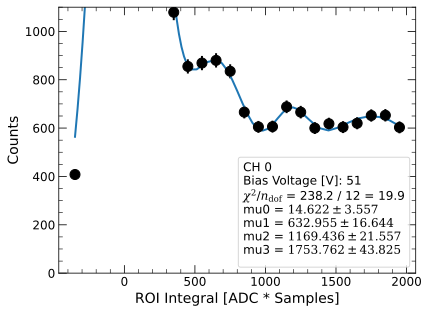

In [134]:
fig, ax = plt.subplots()
ax.set(ylabel="Counts", xlabel=h1.axes[0].label, ylim=(0, 1100))
m.migrad()
m.visualize()
fit_info = [
    f"CH {sipm_ch}",
    f"{h1.axes[3].label}: {sipm_v}",
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    if "mu" in p:
        fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

ax.legend(title="\n".join(fit_info));  # fmt: skip

In [71]:
voltage_range = slice(50.25j, 52.25j, None)
sipm_channels = [0, 1, 2, 3, 4, 5, 6, 7, 9]
fit_val_df, fit_err_df = evalrois.get_spe_fits(
    h1, sipm_channels, voltage_range, peak_sep=500, rebin=20, peak_width_override=120
)
fit_val_df["spe_mean"] = (
    fit_val_df["mu1"] + (fit_val_df["mu2"] / 2) + (fit_val_df["mu3"] / 3)
) / 3
fit_val_df.to_csv("files/Run16_SPE_fit_values.csv", index=False)

-    Channel numbers correspond to the channel number in the digitizer software, so if a channel on the digitizer was broken, it will not present. Fits were possible on some, but not all channels below 51V. Consequently, we believe 51V is an optimal bias voltage that preserves SPEs on all SiPM channels while mitigating the downsides of higher bias voltages like afterpulsing.

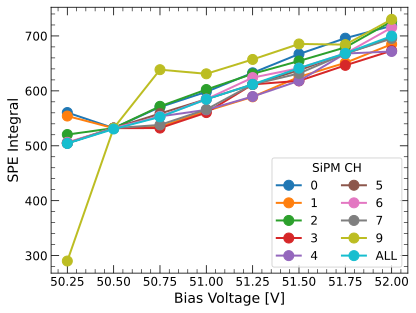

In [15]:
# | label: gain-curves-16

fig, ax = plt.subplots()
fit_val_df.groupby(["sipm_ch"]).plot(x="sipm_v", y="spe_mean", ax=ax, marker="o")
# groupby here is used strictly to retrieve channel labels, not to perform calculations
ch_labels = fit_val_df.groupby(["sipm_ch"]).mean().index.to_list()
ax.legend(title="SiPM CH", labels=ch_labels, ncols=2)
ax.set(xlabel=h1.axes[3].label, ylabel="SPE Integral");  # fmt: skip

## Backup

## Suspcious Fit


-   Fit fails with auto-detection of peaks. Large reduced $\chi^2$ may be indicative of overfit.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


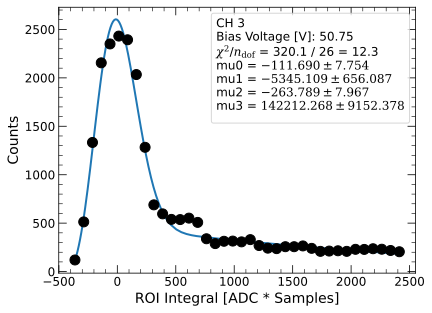

In [16]:
# | label: 16-sus-fit

sipm_ch = 3
sipm_v = 50.75
h_test = h1[:, sum, sipm_ch, complex(0, sipm_v)]
curve = Gaussian(sumgaus_peaks=4)
fit_range = slice(-400j, 2500j, 15j)
first_guess = h_test.get_gaus_params_from_peak_loc(
    [0, 600, 1150, 1650], width_override=125
)
lsqs = h_test[fit_range].get_least_squares(curve.sumgaus)
m = Minuit(lsqs, *first_guess, name=curve.get_sumgaus_param_names())
fig, ax = plt.subplots()

ax.set(ylabel="Counts", xlabel=h1.axes[0].label)
m.migrad()
m.visualize()
fit_info = [
    f"CH {sipm_ch}",
    f"{h1.axes[3].label}: {sipm_v}",
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    if "mu" in p:
        fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

ax.legend(title="\n".join(fit_info));  # fmt: skip

## ROI Integral vs. Amplitude


In [17]:
roi_data = ak.from_parquet(f2)
h1 = evalrois.make_hist(
    v_bins=9,
    v_start=50,
    v_stop=52.25,
    roi_data=roi_data,
    integral_nbins=125,
    peak_amp_nbins=250,
)

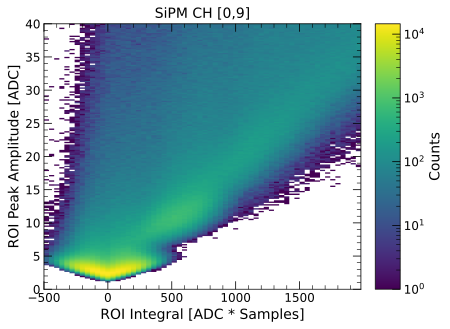

In [18]:
# | label: 16-integ-vs-amp

fig, ax = plt.subplots()
artists = h1[:2000j, :40j, sum, sum].plot(ax=ax, norm=LogNorm(), flow=None)
ax.set(title="SiPM CH [0,9]")
fig.axes[1].set(ylabel="Counts")
artists[0].set_rasterized(True)

## Making a Custom Dataset

-   Looping over events in pure python is slow
-   Instead, consider calling a loop written in C++ from python
-   See [daqman2pyroot](https://lc.llnl.gov/gitlab/nlwg/users/emiz/daqman2pyroot) for tutorials

![](figs/evalrois_softstruct.svg)